# AutoGluon으로 엔비디아(NVDA) 주가 분석
* 엔비디아 주식 yahoo finance에서 2014 ~ 2024.10.16 까지 불러오기
* 데이터 표시
* 종가를 타겟 변수로 지정
* AutoGluon을 이용해 시계열 분석
* 30일 예측 결과 출력 

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

# 밑에 실행하면서 뜨는 빨간 경고 팝업 뜨지 않게 하기

In [2]:
# !pip install yfinance

In [3]:
import os
import pandas as pd
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame


### yahoo finance에서 엔비디아 주식 불러오기 

In [4]:
# 엔비디아 주식 데이터 다운로드

def load_nvidia_data():
    ticker = 'NVDA'
    start_date = '2014-01-01'
    end_date = '2024-10-16'
    
    # 데이터 다운로드 (전체 데이터)
    return yf.download(ticker, start=start_date, end=end_date)

# 데이터 로드
nvda_data = load_nvidia_data()

# 데이터 출력
nvda_data


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,0.398000,0.399500,0.393000,0.396500,0.373992,260092000
2014-01-03,0.397250,0.398000,0.390500,0.391750,0.369512,259332000
2014-01-06,0.395750,0.400000,0.392000,0.397000,0.374464,409492000
2014-01-07,0.401000,0.405000,0.398250,0.403500,0.380595,333288000
2014-01-08,0.405000,0.411000,0.403500,0.409000,0.385782,308192000
...,...,...,...,...,...,...
2024-10-09,134.110001,134.520004,131.380005,132.649994,132.649994,246191600
2024-10-10,131.910004,135.000000,131.000000,134.809998,134.809998,242311300
2024-10-11,134.009995,135.779999,133.660004,134.800003,134.800003,170209500


### 칼럼명

- Open: 주식의 당일 시가
- High: 당일의 최고가
- Low: 당일의 최저가
- Close: 주식의 종가
- Adj Close: 조정된 종가, 배당금과 주식 분할을 반영한 종가
- Volume: 당일 주식의 거래량

## 종가(close) 기준으로 데이터 시각화
2014년부터 2024년까지의 엔비디아 종가를 나타내는 라인 차트

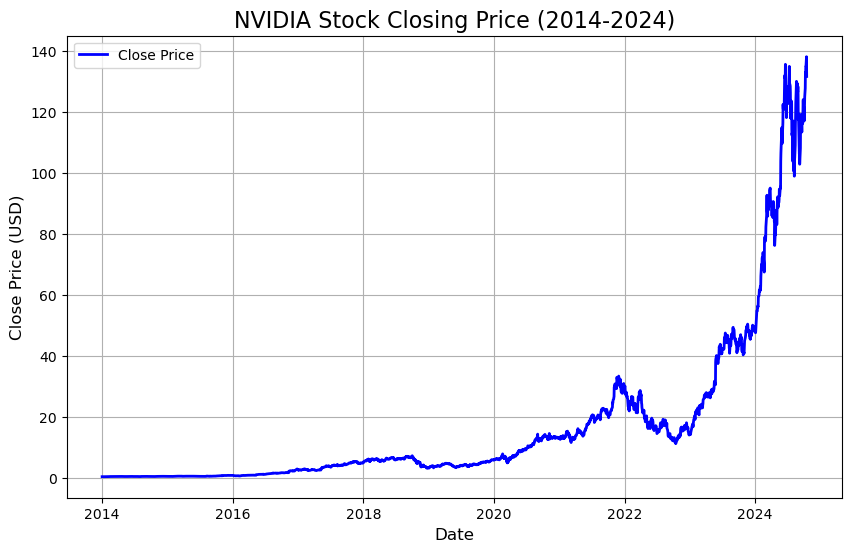

In [5]:
# 종가 기준 그래프 그리기

plt.figure(figsize=(10, 6))
plt.plot(nvda_data.index, nvda_data['Close'], label='Close Price', color='b', linewidth=2)
plt.title('NVIDIA Stock Closing Price (2014-2024)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price (USD)', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

## 이동평균선(MA)으로 주가의 단기적 ~ 장기적 추세 확인하기 
이동평균선을 통해 주가의 추세 반전을 감지할 수 있다.

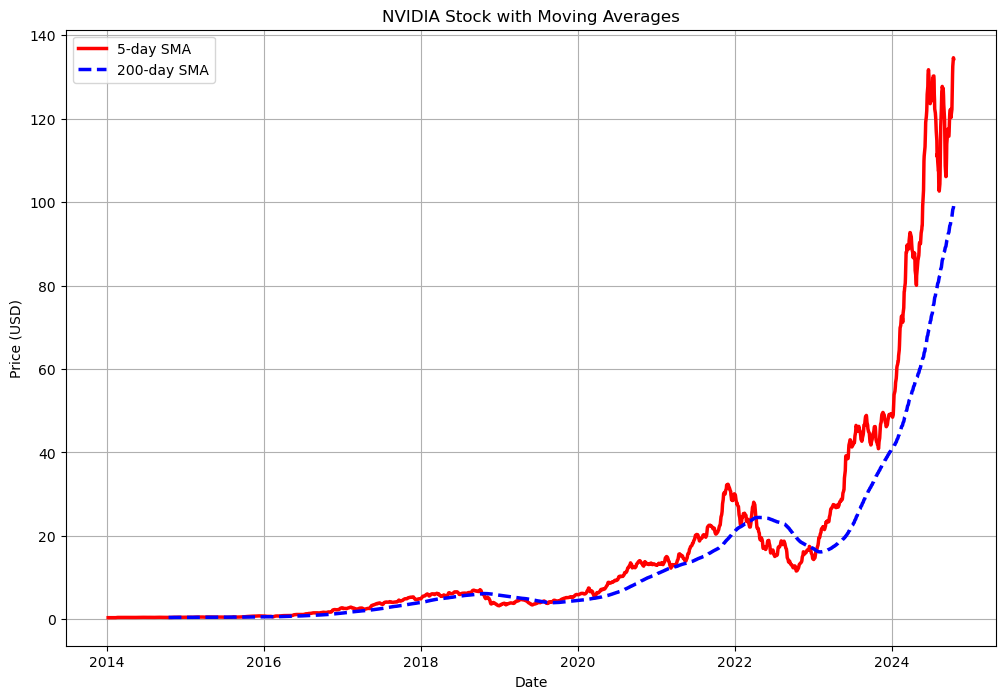

In [7]:
# 이동평균 계산 (5일, 20일, 50일, 200일)

nvda_data['SMA_5'] = nvda_data['Close'].rolling(window=5).mean()
#nvda_data['SMA_20'] = nvda_data['Close'].rolling(window=20).mean()
#nvda_data['SMA_50'] = nvda_data['Close'].rolling(window=50).mean()
nvda_data['SMA_200'] = nvda_data['Close'].rolling(window=200).mean()



# 이동평균선 시각화
plt.figure(figsize=(12, 8))
#plt.plot(nvda_data.index, nvda_data['Close'], label='Close Price', color='b', linewidth=2)
plt.plot(nvda_data.index, nvda_data['SMA_5'], label='5-day SMA', color='r', linewidth=2.5)
#plt.plot(nvda_data.index, nvda_data['SMA_20'], label='20-day SMA', color='r', linestyle='--')
#plt.plot(nvda_data.index, nvda_data['SMA_50'], label='50-day SMA', color='y', linestyle='--')
plt.plot(nvda_data.index, nvda_data['SMA_200'], label='200-day SMA', color='b', linestyle='--', linewidth=2.5)
plt.title('NVIDIA Stock with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


* 단기이동평균(5일)은 주가의 단기적인 흐름
* 장기이동평균(200일)은 주가의 장기적인 흐름

단기이동평균선(red)이 장기이동평균선(blue)을 넘을 때는 매수 신호(골든 크로스) <br>
반대로 단기이동평균선(red)이 장기이동평균선(blue) 아래로 내려갈 때는 매도 신호(데드 크로스)로 해석될 수 있다.

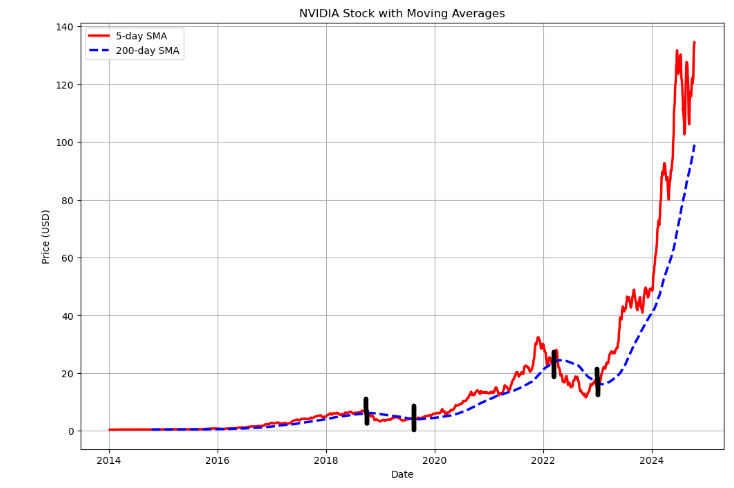

* 2022년 이후 주가의 가파른 상승이 눈에 띈다.
* 그래프에서 명확한 골든 크로스가 나타나는 시점은 없지만, 2020년 이전에는 두 이동평균선이 서로 가까이 위치해 있던 시기를 통해 주가의 추세 전환을 예측할 수 있었을 것이다.
* 주가가 급격하게 상승한 2022년 이후, 단기 이동평균선이 장기 이동평균선보다 훨씬 위에 위치한 것을 볼 수 있다. 이는 주가가 단기적으로 급등했음을 의미하며, 장기적으로도 주가가 상승할 가능성이 있음을 나타낸다. 

# 최종 코드 

[*********************100%***********************]  1 of 1 completed
Beginning AutoGluon training... Time limit = 300s
AutoGluon will save models to 'AutogluonModels/ag-20241017_071718'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.15
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Mar 29 23:14:13 UTC 2024
CPU Count:          12
GPU Count:          0
Memory Avail:       12.83 GB / 15.31 GB (83.8%)
Disk Space Avail:   46.31 GB / 237.85 GB (19.5%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'D',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 30,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'Close',
 'time_limit': 300,
 'verbosity': 2}

train_data with frequency 'None

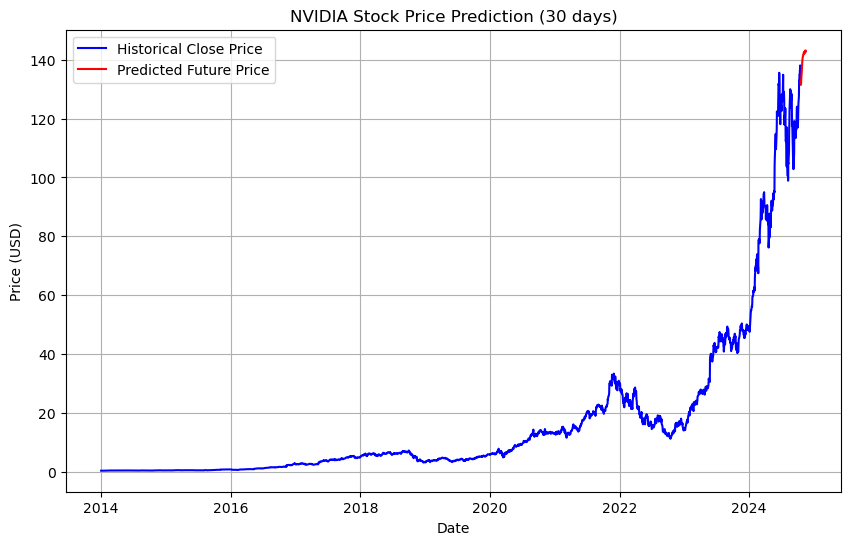

In [4]:
import yfinance as yf
import pandas as pd
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import matplotlib.pyplot as plt

# 1. 엔비디아 주식 데이터 다운로드 (종가 데이터만 사용)
def load_nvidia_data():
    ticker = 'NVDA'
    start_date = '2014-01-01'
    end_date = '2024-10-16'
    
    # 데이터 다운로드
    data = yf.download(ticker, start=start_date, end=end_date)
    
    # 'Date'와 'Close' 컬럼만 선택
    data.reset_index(inplace=True)  # 인덱스를 리셋해 'Date'를 열로 만듦
    return data[['Date', 'Close']]

# 데이터 로드
nvda_data = load_nvidia_data()

# 2. 데이터에 item_id 추가 (단일 시계열로 'NVDA' 사용)
nvda_data['item_id'] = 'NVDA'  # 모든 데이터에 동일한 item_id 부여

# 3. 데이터를 TimeSeriesDataFrame 형식으로 변환
train_data = TimeSeriesDataFrame.from_data_frame(
    nvda_data, 
    id_column="item_id",  # item_id 설정
    timestamp_column="Date"  # timestamp로 사용할 열 설정
)

# 4. AutoGluon TimeSeriesPredictor 설정 (빈도 'D'로 설정)
target_column = "Close"
prediction_length = 30  # 30일 후의 주가 예측

predictor = TimeSeriesPredictor(
    target=target_column,  # 타겟 변수 설정
    prediction_length=prediction_length,  # 예측할 기간
    freq='D',  # 데이터 빈도 설정 (일일)
    eval_metric='mean_wQuantileLoss'  # 시계열에 적합한 평가 지표
)

# 5. 모델 학습 (time_limit은 fit()에서 지정)
predictor.fit(train_data, time_limit=300)  # 5분 시간 제한

# 6. 30일 후의 주가 예측
predictions = predictor.predict(train_data)


# 7. 예측 결과 시각화
# predictions 데이터의 인덱스를 reset하여 그래프에 맞는 형식으로 변환
predictions = predictions.reset_index()

plt.figure(figsize=(10, 6))
plt.plot(nvda_data['Date'], nvda_data['Close'], label='Historical Close Price', color='blue')
plt.plot(predictions['timestamp'], predictions['mean'], label='Predicted Future Price', color='red')
plt.title('NVIDIA Stock Price Prediction (30 days)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


- 빨간색 선은 다음 30일 동안의 예측된 주가를 나타낸다. 예측에 따르면, 단기적으로 주가가 계속 상승할 가능성이 높다고 판단된다.
- 주가의 움직임은 다소 완만하게 상승할 것으로 예측되었으며, 과거처럼 급격한 변동성은 보이지 않고 안정적인 상승이 예상된다.

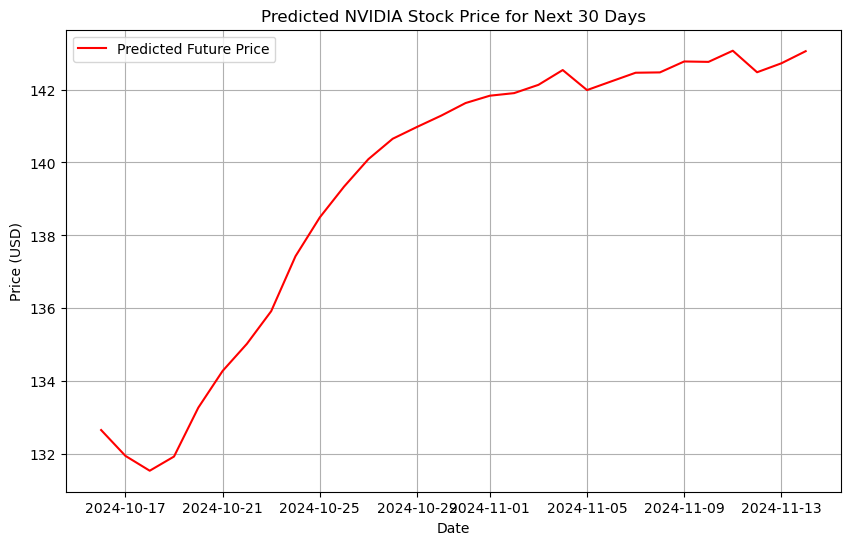

In [5]:
# 30일 예측 주가만 시각화

plt.figure(figsize=(10, 6))
plt.plot(predictions['timestamp'], predictions['mean'], label='Predicted Future Price', color='red')
plt.title('Predicted NVIDIA Stock Price for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


해석 : AutoGluon 을 사용해 다음 30일간의 주가 추이를 예측했다. 30일 동안 급격한 상승이 나타날 가능성이 크다.

## 거래량과 종가의 상관관계 분석
* 거래량(Volume)은 주가가 움직이는 동안 얼마나 많은 거래가 발생했는지 보여준다. 거래량과 주가의 상관관계를 시각화하면 강세시장과 약세시장을 분석할 수 있다. 

In [7]:
# 엔비디아 주식 데이터 다운로드

def load_nvidia_data():
    ticker = 'NVDA'
    start_date = '2014-01-01'
    end_date = '2024-10-16'
    
    # 데이터 다운로드 (전체 데이터)
    return yf.download(ticker, start=start_date, end=end_date)

# 데이터 로드
nvda_data = load_nvidia_data()

# 데이터 출력
nvda_data


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,0.398000,0.399500,0.393000,0.396500,0.373992,260092000
2014-01-03,0.397250,0.398000,0.390500,0.391750,0.369512,259332000
2014-01-06,0.395750,0.400000,0.392000,0.397000,0.374464,409492000
2014-01-07,0.401000,0.405000,0.398250,0.403500,0.380595,333288000
2014-01-08,0.405000,0.411000,0.403500,0.409000,0.385782,308192000
...,...,...,...,...,...,...
2024-10-09,134.110001,134.520004,131.380005,132.649994,132.649994,246191600
2024-10-10,131.910004,135.000000,131.000000,134.809998,134.809998,242311300
2024-10-11,134.009995,135.779999,133.660004,134.800003,134.800003,170209500


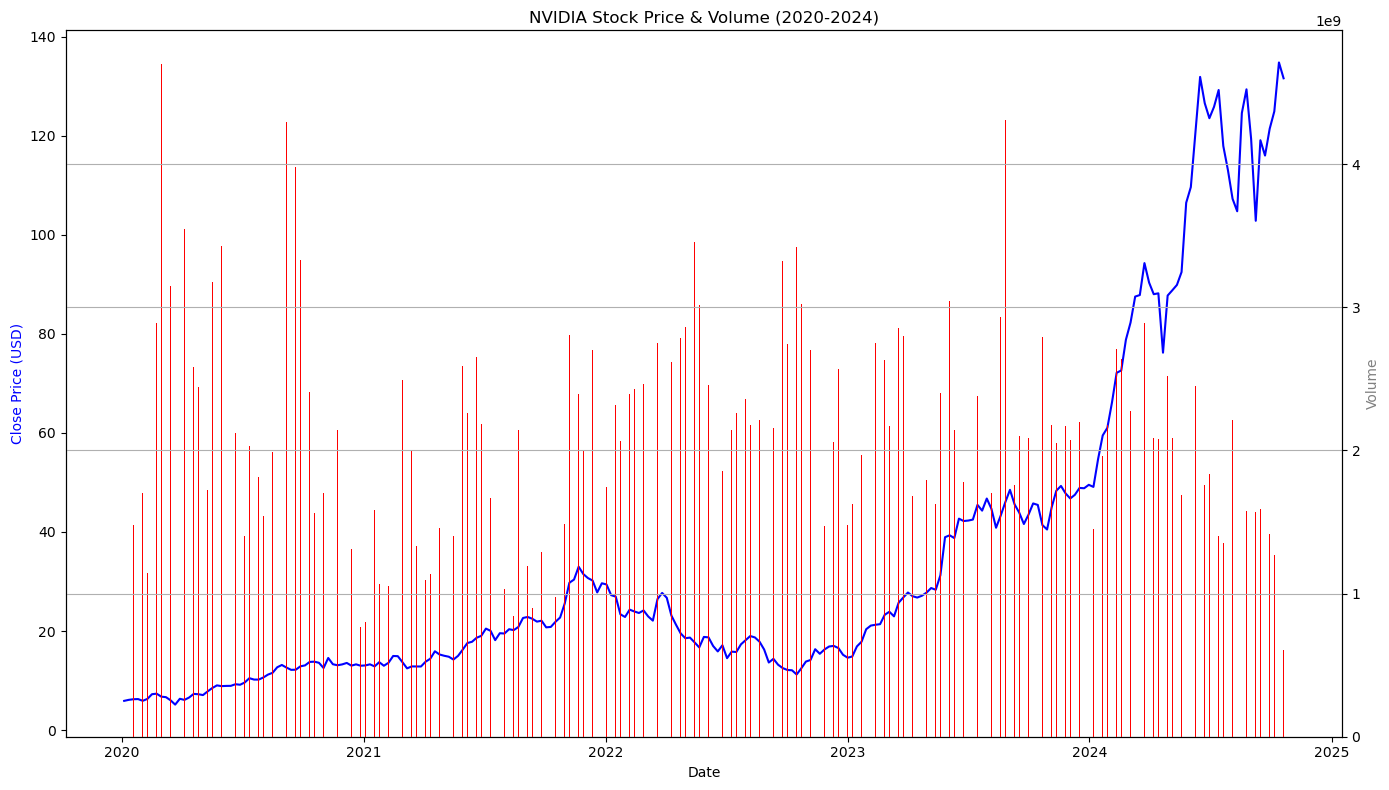

In [21]:
import matplotlib.dates as mdates


# 2020-01-01 부터 현재까지의 데이터 필터링
nvda_data_filtered = nvda_data[nvda_data.index >= '2020-01-01']

# 거래량을 주간 단위로 리샘플링 (주간합계)
nvda_data_filtered_weekly = nvda_data_filtered.resample('W').agg({
    'Close': 'last', # 주간 마지막 종가
    'Volume': 'sum' # 주간 거래량 합계
})

# 거래량과 주가 시각화
fig, ax1 = plt.subplots(figsize=(14, 8))

# 주가 시각화 (종가)
ax1.plot(nvda_data_filtered_weekly.index, nvda_data_filtered_weekly['Close'], color='blue', label='Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price (USD)', color='blue')


# 날짜 축 간격을 1년 단위로 설정 
ax1.xaxis.set_major_locator(mdates.YearLocator(1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


# 거래량 시각화 (막대 그래프)
ax2 = ax1.twinx()
ax2.bar(nvda_data_filtered_weekly.index, nvda_data_filtered_weekly['Volume'], color='red', alpha=1, label='Volume')
ax2.set_ylabel('Volume', color='gray')

plt.title('NVIDIA Stock Price & Volume (2020-2024)')
fig.tight_layout()
plt.grid(True)
plt.show()


분석 의미:
- 거래량 급증 시 주가가 상승한다면, 이는 강한 매수세가 있음을 의미하고, 거래량이 적음에도 주가가 상승한다면 이는 약한 상승 신호로 해석할 수 있다.
- 거래량이 급감하면서 주가가 하락하면 매도세가 우세하다는 신호일 수 있다.

## 동종업계인 반도체산업 비교 분석

1. AMD (Advanced Micro Devices, Inc.) : AMD <br>
엔비디아와 GPU 시장에서 직접 경쟁하며, 두 회사는 그래픽 카드 및 인공지능(AI) 관련 기술에서 경쟁하고 있다. 특히 GPU 성능과 데이터 센터 관련 기술이 비슷하다. <br><br>

2. Intel (Intel Corporation) : INTC <br>
CPU 시장에서 강자이며, 엔비디아의 GPU와는 상호 보완적인 관계에 있다. 인텔 또한 AI 및 데이터 센터 기술을 확장하고 있으므로, 엔비디아와의 기술 비교가 가능하다. <br><br>

3. TSMC (Taiwan Semiconductor Manufacturing Company) : TSM <br>
엔비디아의 칩을 위탁 생산하는 반도체 파운드리 업체로, 엔비디아의 공급망과 밀접한 관련이 있다. 반도체 제조 기술 및 칩 생산 공정에서 중요한 역할을 한다. <br><br>
 
4. 마이크론 테크놀로지 (Micron Technology) : MU <br>
메모리 반도체 제조업체로, 엔비디아의 GPU와 함께 메모리 기술은 고성능 컴퓨팅에서 중요한 역할을 한다. 데이터 센터와 AI 인프라에서 두 회사의 기술이 상호 보완적이다. <br><br>


[*********************100%***********************]  5 of 5 completed


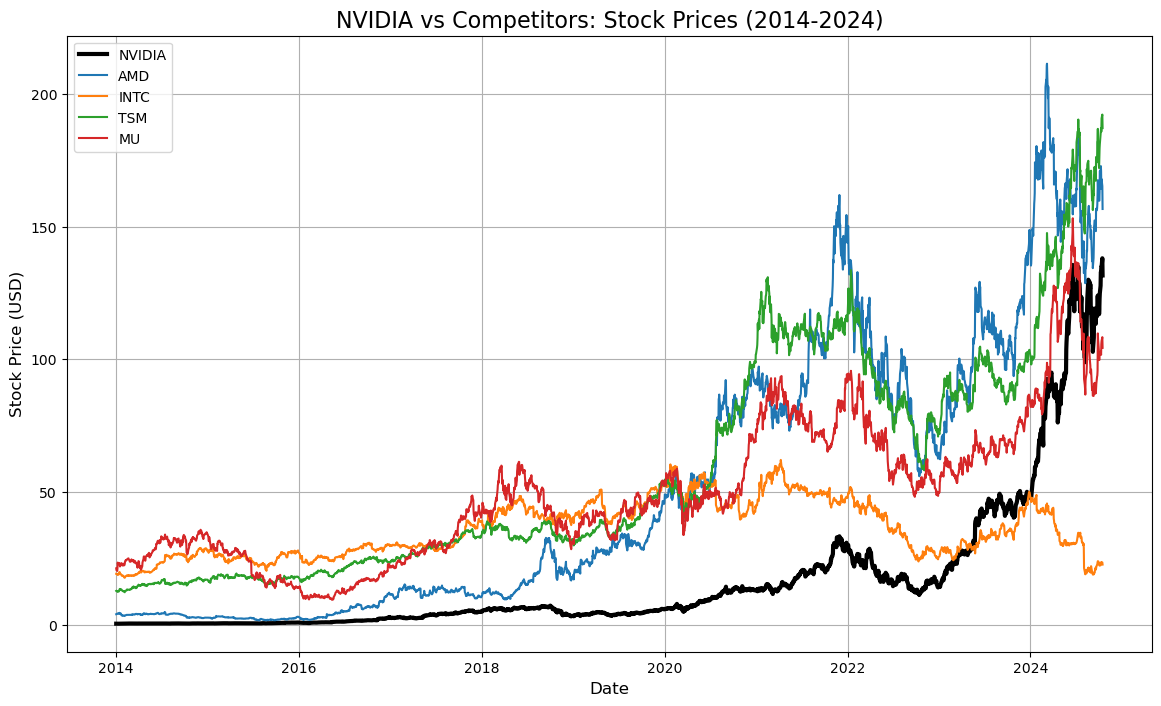

In [18]:
# 1. 기업 티커 목록
tickers = ['NVDA', 'AMD', 'INTC', 'TSM', 'MU']

# 2. 데이터 다운로드 (2014년부터 2024년까지)
start_date = '2014-01-01'
end_date = '2024-10-16'

# 각 기업의 주가 데이터를 다운로드
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# 3. 시각화
plt.figure(figsize=(14, 8))

# NVIDIA는 굵은 빨간색 선으로 표시
plt.plot(data.index, data['NVDA'], label='NVIDIA', color='black', linewidth=3)

# 나머지 기업들은 기본 설정으로 표시
for ticker in tickers:
    if ticker != 'NVDA':  # 엔비디아 외 다른 기업들
        plt.plot(data.index, data[ticker], label=ticker)

plt.title('NVIDIA vs Competitors: Stock Prices (2014-2024)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price (USD)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


## 수익률과 거래량의 상관관계 분석
* 주식의 일일 수익률과 거래량 간의 상관관계를 분석하여, 주가 변동이 클 때 거래량이 어떻게 변했는지 파악할 수 있다.
* 산점도를 통해 주가 변동과 거래량의 관계를 시각적으로 분석할 수 있으며, 이를 통해 거래량 급증 시 주가 변동 패턴을 알 수 있다. 

<br><br>

1. 일일 수익률 계산:
- 일일 수익률은 매일 주가가 얼마나 변화했는지를 나타낸다. 


$$
\text{일일 수익률} = \left( \frac{\text{오늘의 종가 (Adj Close)}}{\text{어제의 종가 (Adj Close)}} - 1 \right) \times 100
$$


2. 수익률과 거래량의 상관관계 분석:
- 각 일일 수익률과 그날의 거래량 간 상관관계를 확인하여, 주가 변동이 클 때 거래량이 함께 변동하는지 파악한다.

* Adj Close : 조정된 종가는 배당금과 주식 분할 등의 변동을 반영한 가격이므로, 실제 수익률을 계산할 때 적합한 값

[*********************100%***********************]  1 of 1 completed


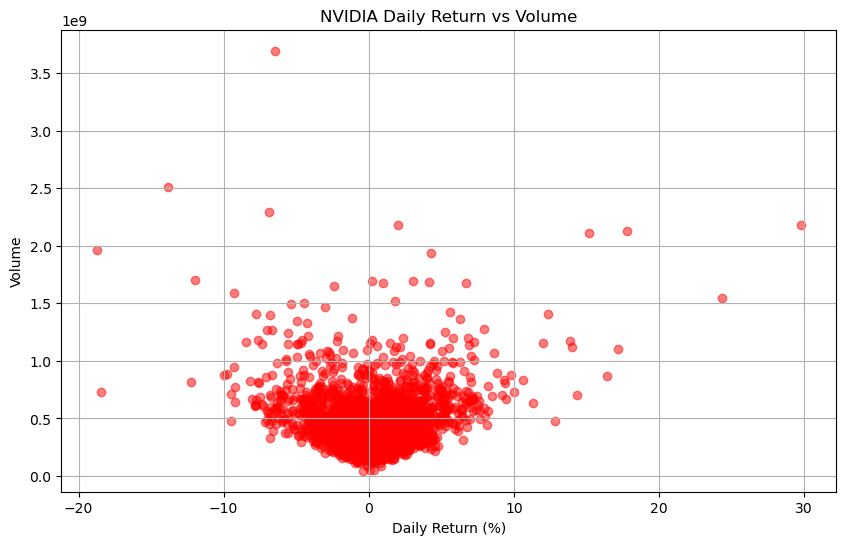

Correlation between Daily Return and Volume:
              Daily Return    Volume
Daily Return      1.000000  0.045708
Volume            0.045708  1.000000


In [19]:

# 1. 데이터 다운로드 (NVDA 데이터 예시로 사용)
ticker = 'NVDA'
start_date = '2014-01-01'
end_date = '2024-10-16'

nvda_data = yf.download(ticker, start=start_date, end=end_date)

# 2. 일일 수익률 계산
nvda_data['Daily Return'] = nvda_data['Adj Close'].pct_change() * 100  # 퍼센트 변화로 계산

# 3. 수익률과 거래량의 상관관계 시각화 (산점도)
plt.figure(figsize=(10, 6))
plt.scatter(nvda_data['Daily Return'], nvda_data['Volume'], alpha=0.5, color='red')
plt.title('NVIDIA Daily Return vs Volume')
plt.xlabel('Daily Return (%)')
plt.ylabel('Volume')
plt.grid(True)
plt.show()

# 4. 상관계수 계산 (수익률과 거래량)
correlation = nvda_data[['Daily Return', 'Volume']].corr()
print("Correlation between Daily Return and Volume:")
print(correlation)
